<a href="https://colab.research.google.com/github/CristianCosci/bitcoin_OHLCV_dataset_generator/blob/main/bitcoinOHLCV_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
from tqdm import *
import matplotlib.pyplot as plt
import os
import requests
import numpy as np

In [5]:
"""
LIST OF EXCHANGES USED FOR DATA COLLECTION (order by btc volume)
the exchanges were chosen by consulting data on the volume of btc from :
  https://www.bitcointradevolume.com/
  https://coinmarketcap.com/it/currencies/bitcoin/markets/
  https://data.bitcoinity.org/markets/volume/30d?c=e&t=b
  https://www.cryptocompare.com/coins/btc/analysis/USD

  -Coinbase
  -Bitfinex
  -Kraken
  -Bitstamp
  -Itbit
  -Okcoin
"""

def generateBitcoinOHLCV(exchange, compression, exchangeToFill):
  """
  Download exchange data from bitcoincharts.com and building OHLCV candelsticks format
  Formato dei dati (preso direttamente dal sito https://bitcoincharts.com/about/markets-api/):
        
    HISTORICAL TRADE DATA
      returns CSV:
          unixtime,price,amount
  Parameters
  ----------
  exchange : str
      Exchange's name from http://api.bitcoincharts.com/v1/csv/

  compression : int
      minutes for resampling  
    
  exchangeToFill : str
      Name of exchange in which handle missing data

  Returns
  -------
  historicalOHLCV : pd.DataFrame
      Dataframe with historical OHLCV candlesticks
  """

  bitcoinchartsUrl = "http://api.bitcoincharts.com/v1/csv/{}USD.csv.gz".format(exchange)#data in USD currency

  print()
  print("Downloading {} trade data from URL {}".format(exchange, bitcoinchartsUrl))

  historicalTrades = pd.read_csv(bitcoinchartsUrl, names=["unixtime", "price", "amount"], compression='gzip')#reading csv from url
  historicalTrades["datetime"] = pd.to_datetime(historicalTrades["unixtime"], unit="s") #conversion timestamp to datetime
  historicalTrades = historicalTrades.drop("unixtime", axis=1).set_index("datetime").sort_index()

  historicalOHLCV = historicalTrades

  #build OHLCV historical data
  historicalOHLCV["open"] = historicalTrades["price"]
  historicalOHLCV["high"] = historicalTrades["price"]
  historicalOHLCV["low"] = historicalTrades["price"]
  historicalOHLCV["close"] = historicalTrades["price"]
  historicalOHLCV["volume"] = historicalTrades["amount"]

  historicalOHLCV = historicalOHLCV.drop(["price", "amount"], axis=1)

  historicalOHLCV = historicalOHLCV.resample(str(compression) + "min").agg({"open": "first", "high": "max", "low": "min", "close": "last", "volume": "sum"})
    
  if(exchange == exchangeToFill):
    historicalOHLCV = fillNaN(historicalOHLCV)

  historicalOHLCV = historicalOHLCV[~(historicalOHLCV.index < '2012-01-01 00:00:00')] #put the data starts to 2012

  return historicalOHLCV[["open", "high", "low", "close", "volume"]]

def fillNaN(df):
  df["open"] = df["open"].interpolate(method='slinear')
  df["high"] = df["high"].interpolate(method='slinear')
  df["low"] = df["low"].interpolate(method='slinear')
  df["close"] = df["close"].interpolate(method='slinear')
  df["volume"] = df["volume"].interpolate(method='slinear')

  return df[["open", "high", "low", "close", "volume"]]

def aggregateExchangeData(list_dfs):
  """
  Aggregate data from different exchanges to OHLCV candlesticks
  Parameters
  ----------
  list_fds : list of pd.DataFrame
      List of exchanges OHLCV bars as returned by :func:`~generateBitcoinOHLCV`
        
  Returns
  -------
  dfAggregate : pd.DataFrame
      Dataframe containing aggregated OHLC bars from all exchanges
  """
  print("Aggregating OHLCV history data from {} exchanges into a single dataframe".format(len(list_dfs)))
  dfConcat = pd.concat(tuple(list_dfs))
  grp = dfConcat.groupby(dfConcat.index)
  dfAggregate = grp[["open", "high", "low", "close"]].mean()  #the value ar calculated by mean
    
  # Round decimals
  return dfAggregate.round({
      "open": 4,
      "high": 4,
      "low": 4,
      "close": 4,
  })

def creaCartelle():
  if(os.path.isdir("/home/csv")  == False and len("/home/csv")>0):
    os.makedirs("/home/csv")
  if(os.path.isdir("/home/csvPlot")  == False and len("/home/csvPlot")>0):
    os.makedirs("/home/csvPlot")
  
def csv_plot(dfname, df, statsToPlot):
  """
  GRAPHICAL DATAFRAME'S RAPPRESENTATION and save image to /home/csvPlot/
  Parameters
    ----------
    dfname : string
        Exchange's name 
    
    df : pd.DataFrame
      data to plot

    statsToPlot : string
      statistics to plot
        
  """
  fig = plt.figure(figsize=(30, 13))
  plt.title('{} from {}'.format(statsToPlot, dfname))
  df[statsToPlot].plot(label='{}'.format(dfname))
  plt.savefig('/home/csvPlot/{}.png'.format(dfname))
  plt.legend()

def cumulativeCsvPlot(aggregatedData, list_dfs, exchanges, statsToPlot):
  """
  GRAPHICAL DATAFRAMES' RAPPRESENTATION (all in the same plot) and save image to /home/csvPlot/
  Parameters
    ----------
    aggregatedData : pd.DataFrame
      Dataframe containing aggregated OHLCV bars from all exchanges

    list_fds : list of pd.DataFrame
        List of exchanges OHLCV bars as returned by :func:`~generateBitcoinOHLCV`
        
    exchanges : Array
      Containing the names of all the exchanges used

    statsToPlot : string
      statistics to plot
  """
  fig = plt.figure(figsize=(30, 13))
  aggregatedData[statsToPlot].plot(label='Aggregated')
  for exchange in tqdm(exchanges):
    list_dfs[exchange][statsToPlot].plot(label=exchange)

  plt.savefig('/home/csvPlot/aggregated.png')
  plt.title('{} price from every single exchanges and aggregated'.format(statsToPlot))
  plt.legend()

def resumeData(dfname, df):
  """
  Print first and last row for each DataFrame

  Parameters
    ----------
    dfname : string
        Exchange's name 
    
    df : pd.DataFrame
      data to analize
        
  """
  print()
  print("exchange: {}".format(dfname))
  print("---- prima riga ----")
  print(df.iloc[0])
  print()
  print("---- ultima riga ----")
  print(df.iloc[-1])
  print("----------------------")

def resumeNaN(dfname, df):
  """
  Print the NaN rows for the df

  Parameters
    ----------
    dfname : string
      Exchange's name

    df : pd.DataFrame
      data to analize
  """
  is_NaN = df.isnull()
  row_has_NaN = is_NaN.any(axis=1)
  rows_with_NaN = df[row_has_NaN]
  rows_with_NaN.to_csv("/home/nan{}.csv".format(dfname))
  print()
  print("exchange: {}".format(dfname))
  print("----------------------")
  print(rows_with_NaN)
  print()
  print(df.isna().sum())
  print("----------------------")


In [6]:
creaCartelle()

# Define the compression and the output file
compression = 60 #min
outputFile = ""

# Define the exchanges we want to aggregate
exchanges = ["kraken", "coinbase", "bitstamp", "bitfinex", "okcoin", "itbit"]
exchangeToFill = "bitstamp"

print()
print("Aggregating bitcoin trade data from {} exchanges and create {} file containing {}min OHLC bars".format(len(exchanges),outputFile,compression))
print()

OHLCV = {}

for exchange in tqdm(exchanges):
  OHLCV[exchange] = generateBitcoinOHLCV(exchange, compression, exchangeToFill)
  outputFile = "{}_data.csv".format(exchange)
  print("Saving {} rows to file {}".format(len(OHLCV), outputFile))
  print()
  OHLCV[exchange].to_csv("/home/csv/{}".format(outputFile))
    
aggregatedData = aggregateExchangeData(tuple(OHLCV.values()))
aggregatedData["volume"] = OHLCV["bitstamp"]["volume"]#the volume data is taken only from bitstamp exchange

outputFile = "bitcoin_OHLCV.csv"
print("Saving {} rows to file {}".format(len(OHLCV), outputFile))
aggregatedData.to_csv("/home/csv/{}".format(outputFile))

  0%|          | 0/6 [00:00<?, ?it/s]


Aggregating bitcoin trade data from 6 exchanges and create  file containing 60min OHLC bars


Saving 1 rows to file kraken_data.csv



 17%|█▋        | 1/6 [00:56<04:41, 56.24s/it]


Saving 2 rows to file coinbase_data.csv



 33%|███▎      | 2/6 [02:11<04:07, 61.92s/it]


Saving 3 rows to file bitstamp_data.csv



 50%|█████     | 3/6 [03:41<03:31, 70.47s/it]


Saving 4 rows to file bitfinex_data.csv



 67%|██████▋   | 4/6 [03:58<01:48, 54.43s/it]

 83%|████████▎ | 5/6 [04:05<00:39, 39.96s/it]

Saving 5 rows to file okcoin_data.csv


Saving 6 rows to file itbit_data.csv



100%|██████████| 6/6 [04:13<00:00, 42.29s/it]


Aggregating OHLCV history data from 6 exchanges into a single dataframe
Saving 6 rows to file bitcoin_OHLCV.csv


100%|██████████| 6/6 [00:16<00:00,  2.83s/it]


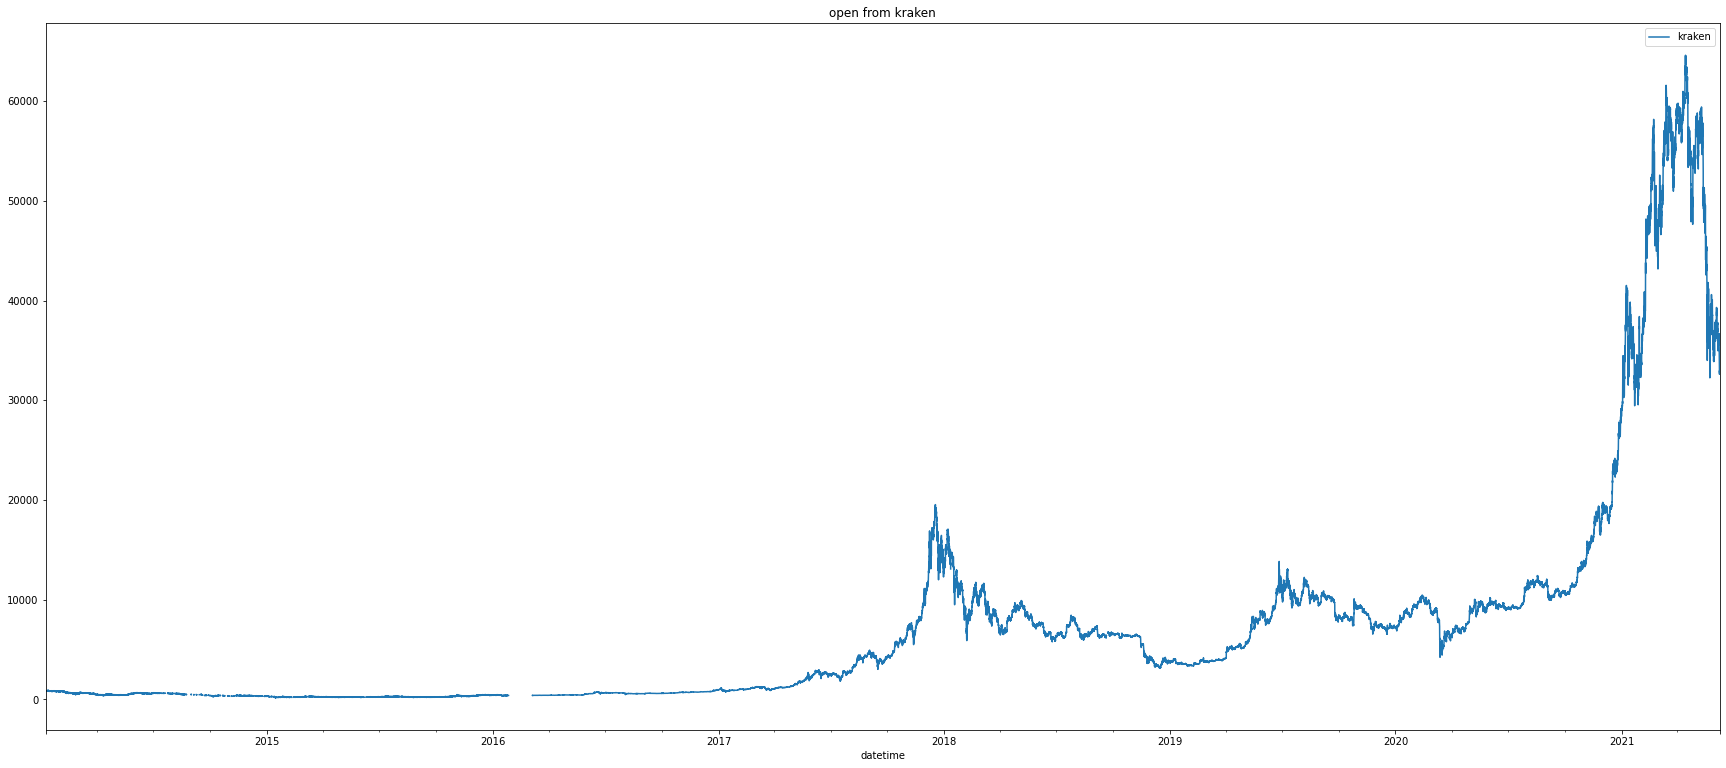

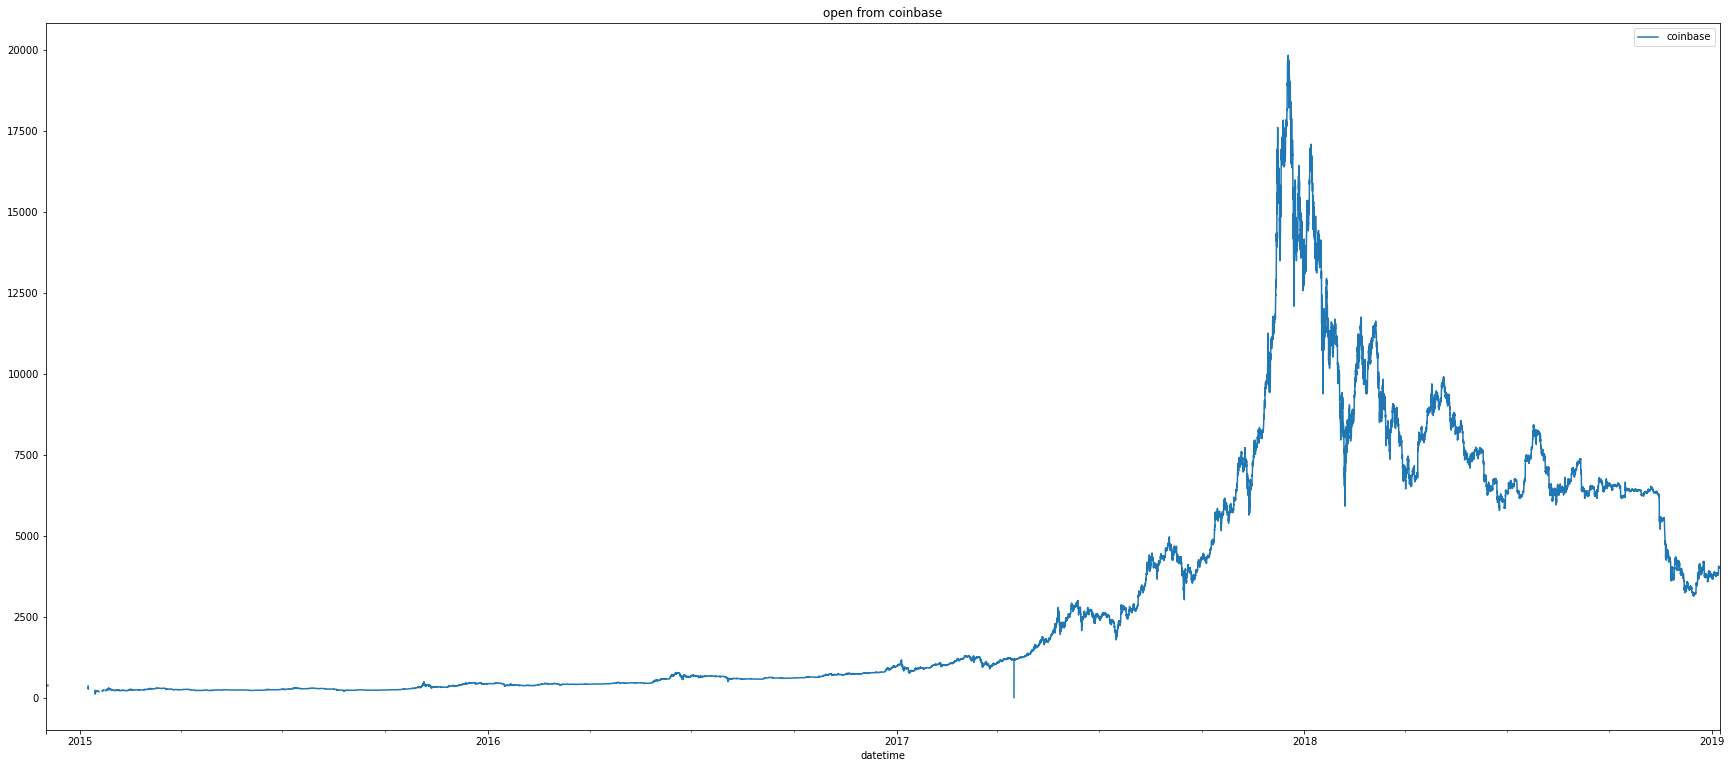

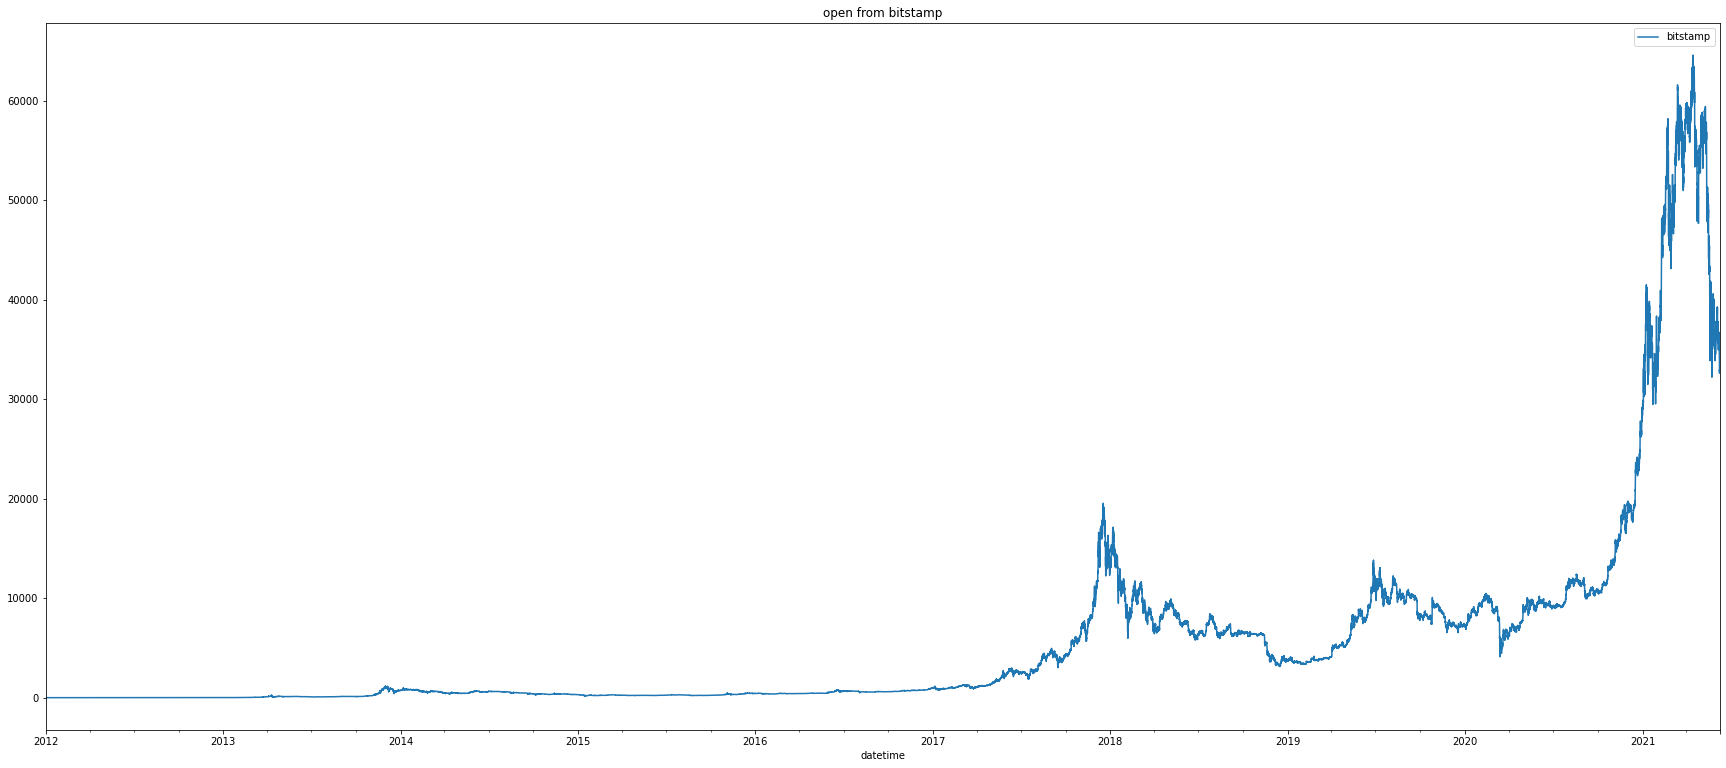

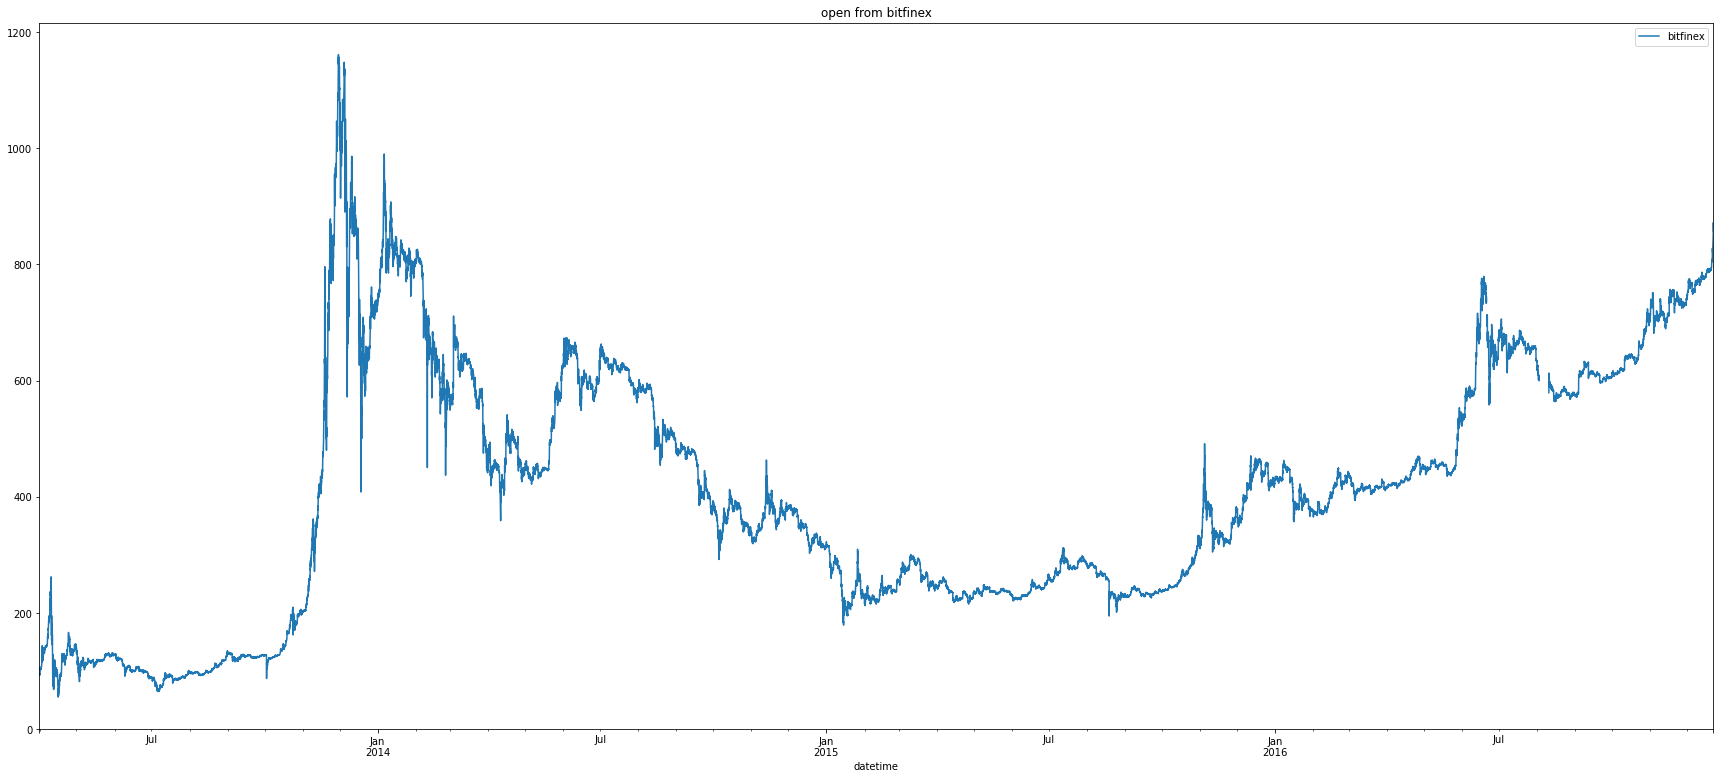

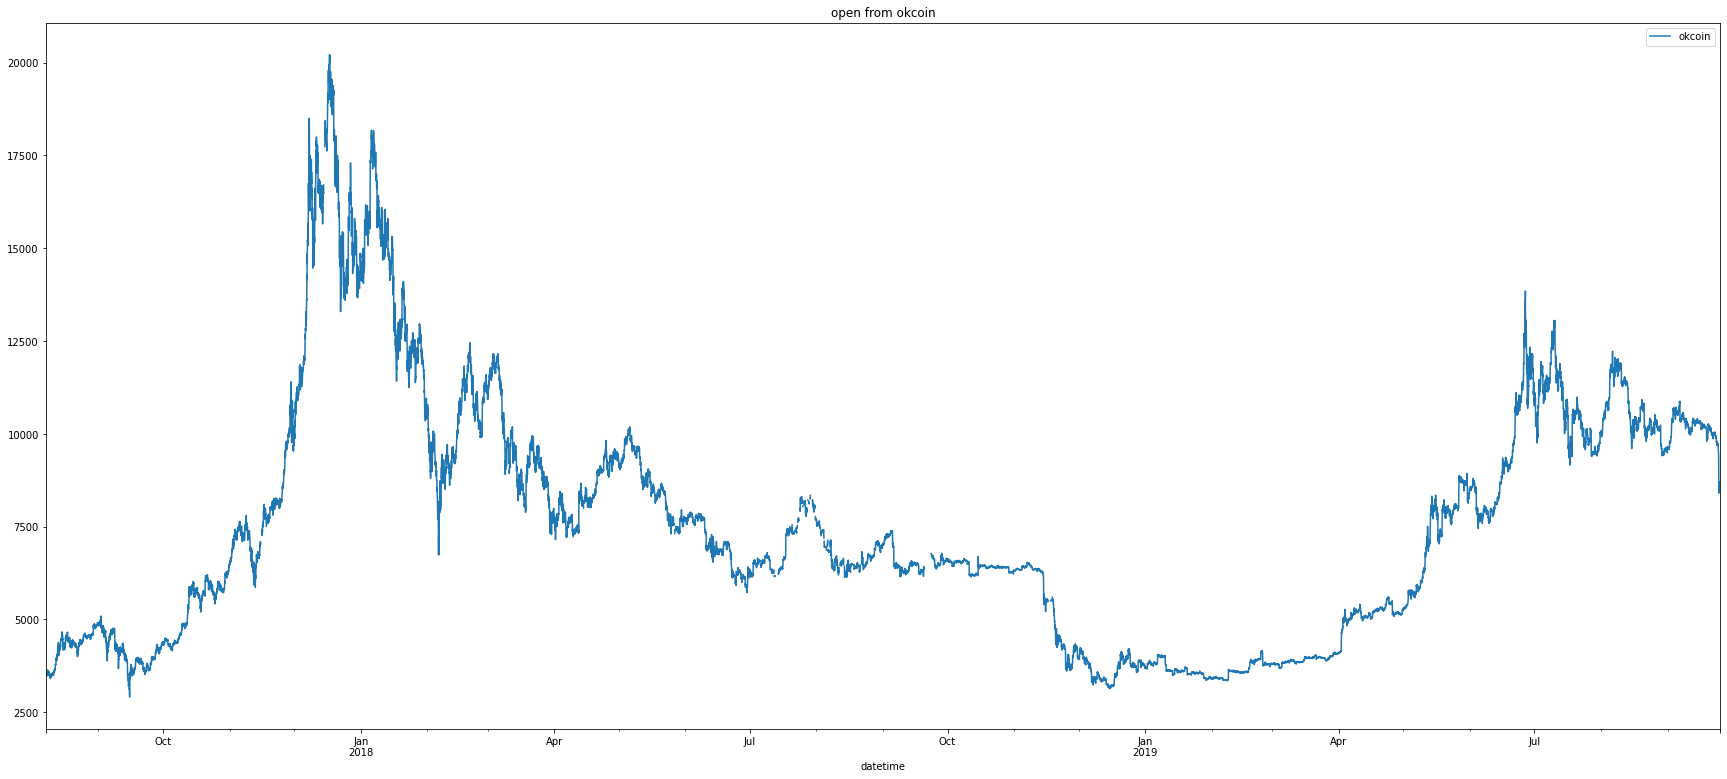

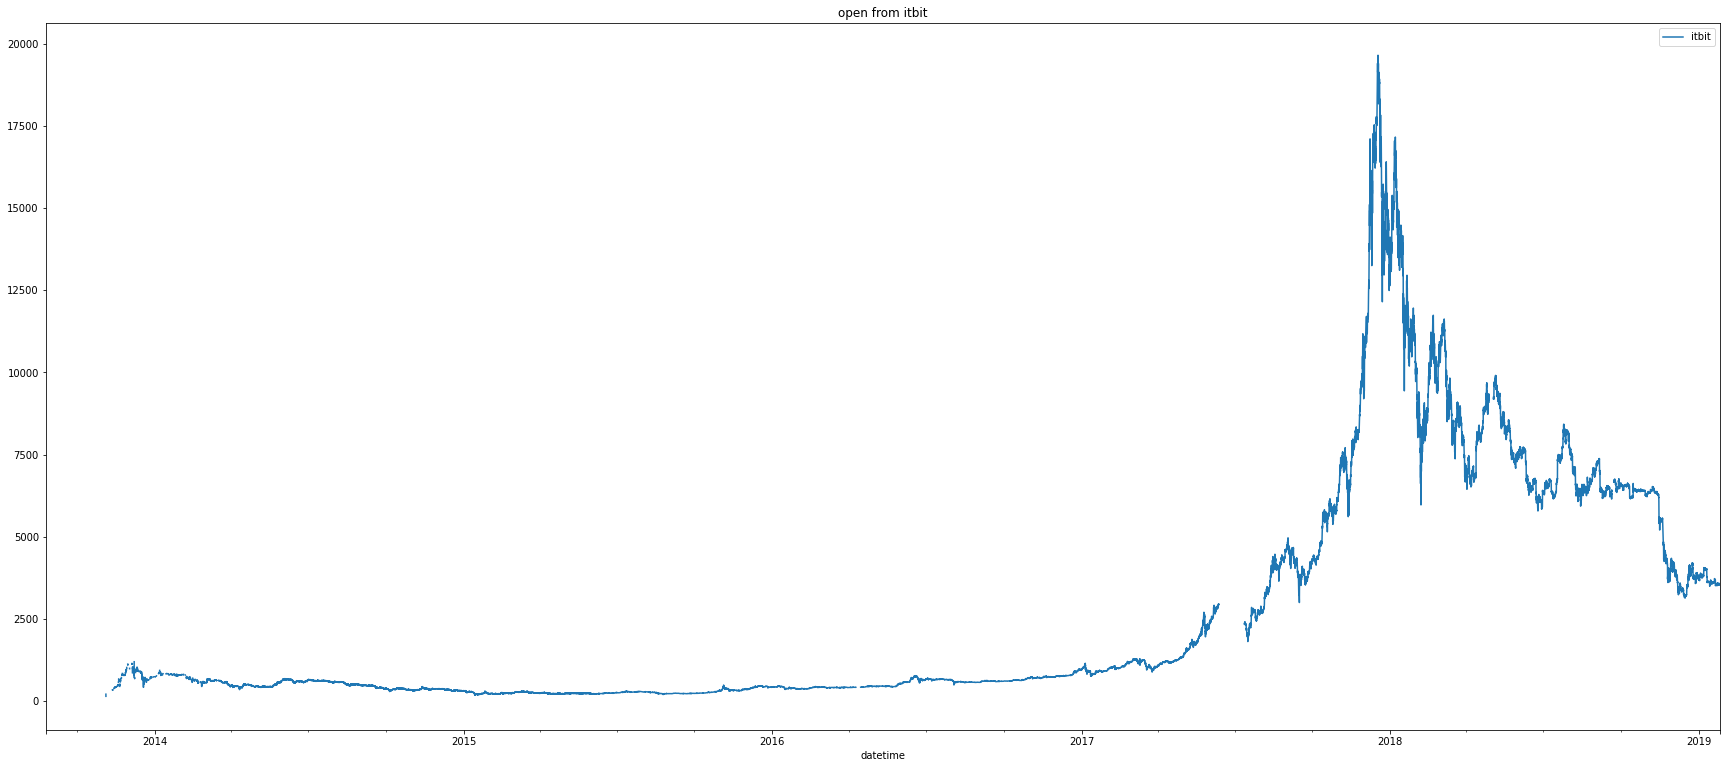

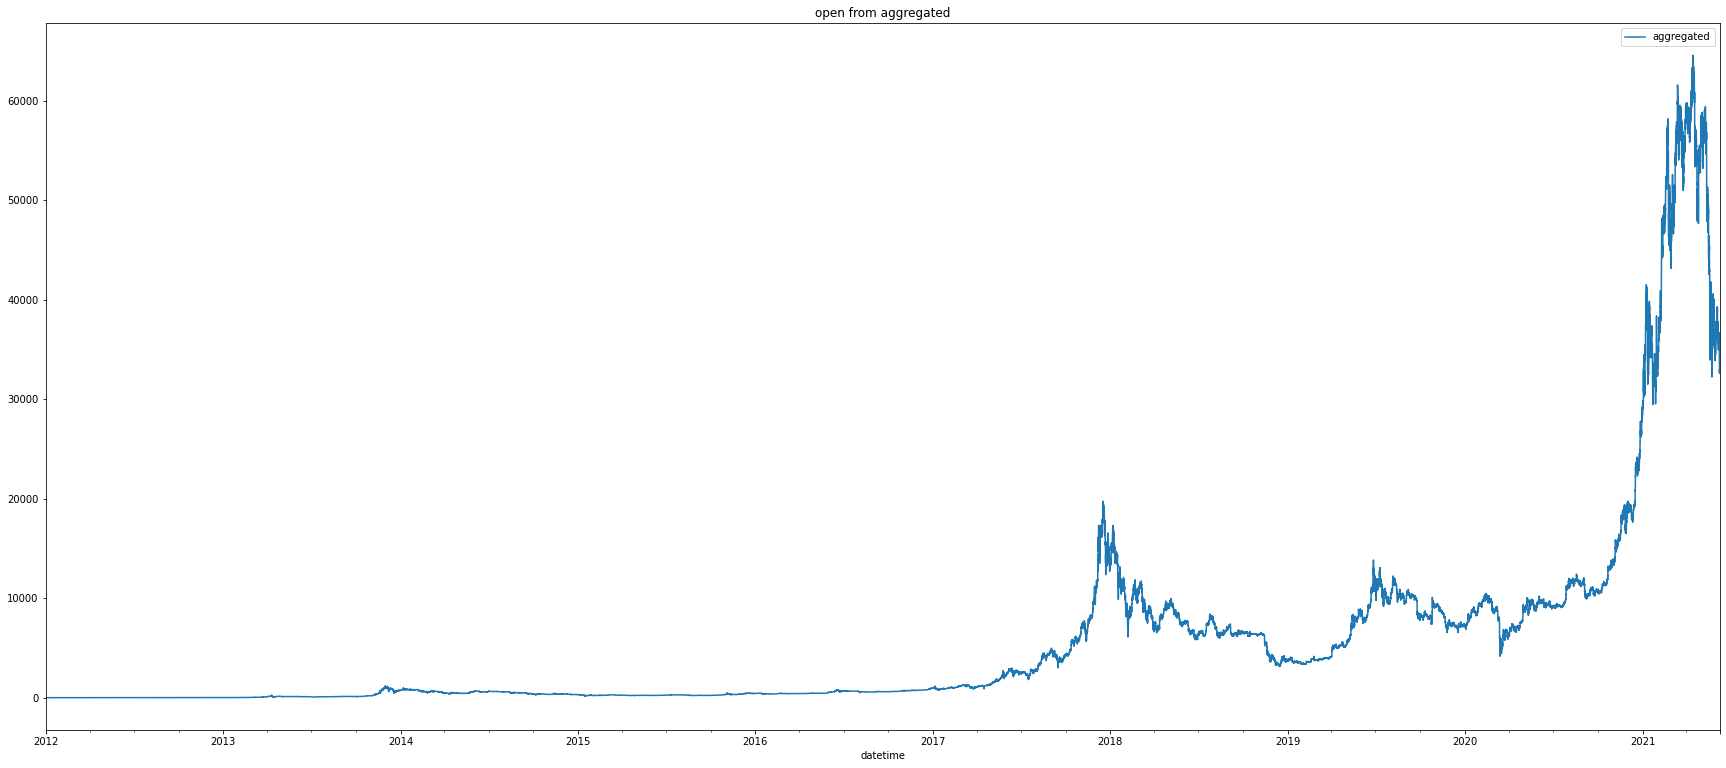

In [7]:
"""
PLOT SINGLE DATAFRAME
"""
stats = "open" #statsToPlot
for exchange in tqdm(exchanges):
  csv_plot(exchange, OHLCV[exchange], stats)

csv_plot("aggregated", aggregatedData, stats)

100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


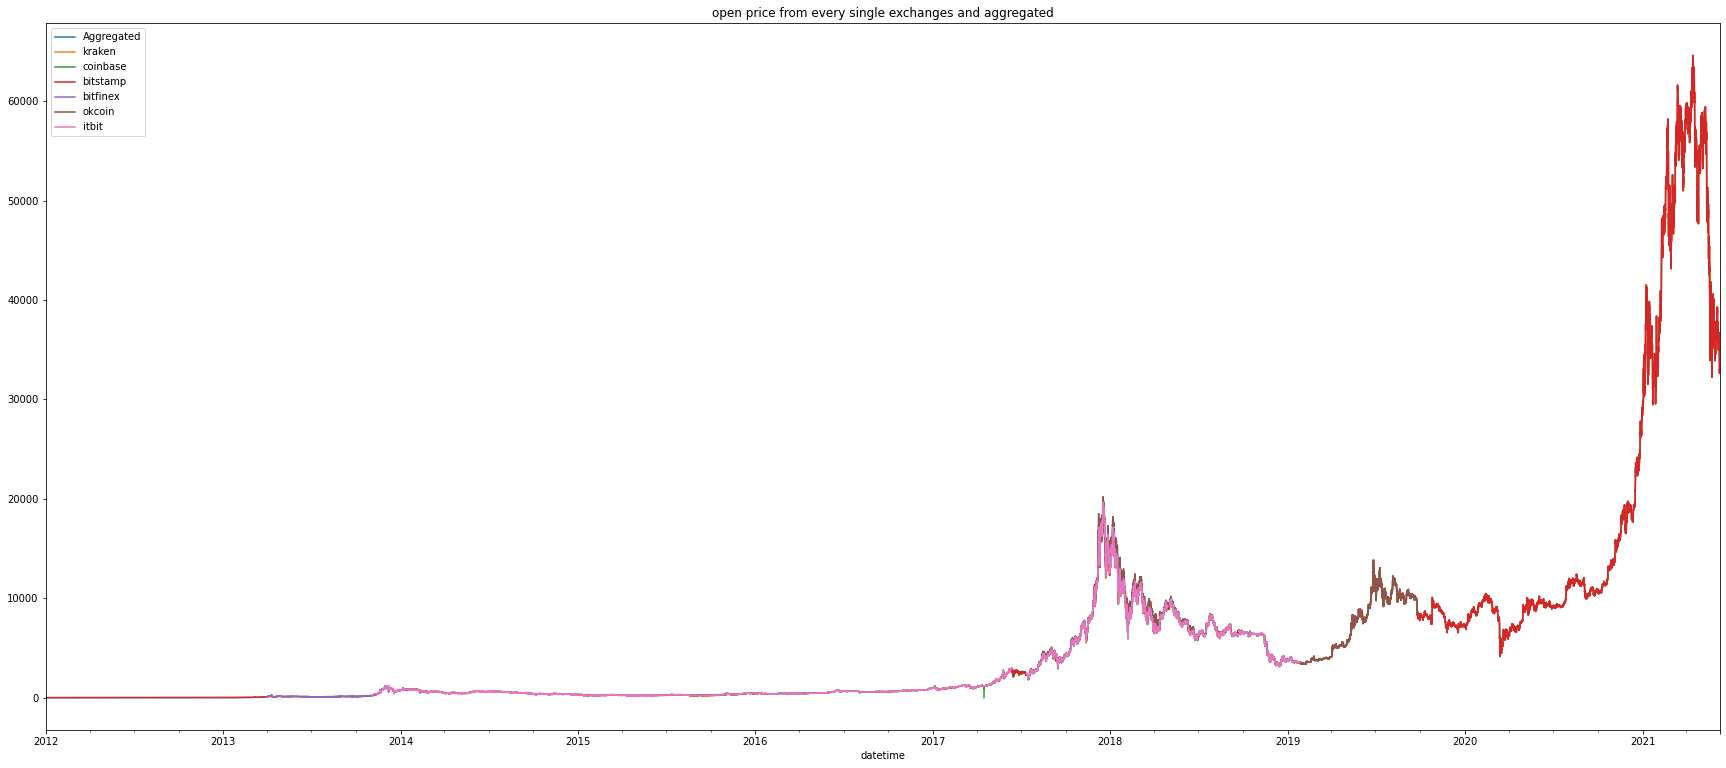

In [8]:
"""
PLOT ALL DATAFRAMES IN THE SAME FIGURE
"""
cumulativeCsvPlot(aggregatedData, OHLCV, exchanges, stats)

In [9]:
"""
PRINT ROW FOR EACH DATAFRAME
"""
for exchange in tqdm(exchanges):
  print()
  print("exchange: {} ----> elementi : {} ".format(exchange, len(OHLCV[exchange]["open"])))

print()
print("aggregated: elementi : {} ".format(len(aggregatedData["open"])))

100%|██████████| 6/6 [00:00<00:00, 1462.87it/s]


exchange: kraken ----> elementi : 65009 

exchange: coinbase ----> elementi : 35970 

exchange: bitstamp ----> elementi : 82715 

exchange: bitfinex ----> elementi : 32679 

exchange: okcoin ----> elementi : 18692 

exchange: itbit ----> elementi : 47515 

aggregated: elementi : 82715 


In [10]:
"""
PRINT FIRST AND LAST ROW FOR EACH DATAFRAME
"""
for exchange in tqdm(exchanges):
  resumeData(exchange, OHLCV[exchange])

resumeData("aggregatedData", aggregatedData)


100%|██████████| 6/6 [00:00<00:00, 251.36it/s]


exchange: kraken
---- prima riga ----
open      874.670400
high      892.067530
low       874.481650
close     874.481650
volume      0.053459
Name: 2014-01-07 18:00:00, dtype: float64

---- ultima riga ----
open      32841.500000
high      33175.000000
low       32713.300000
close     32713.300000
volume       74.719476
Name: 2021-06-08 10:00:00, dtype: float64
----------------------

exchange: coinbase
---- prima riga ----
open      300.00
high      300.00
low       300.00
close     300.00
volume      0.02
Name: 2014-12-01 05:00:00, dtype: float64

---- ultima riga ----
open      4006.560000
high      4006.570000
low       4005.500000
close     4005.990000
volume      25.356712
Name: 2019-01-07 22:00:00, dtype: float64
----------------------

exchange: bitstamp
---- prima riga ----
open      4.58
high      4.58
low       4.58
close     4.58
volume    0.00
Name: 2012-01-01 00:00:00, dtype: float64

---- ultima riga ----
open      32852.100000
high      33192.030000
low       32808.87

In [11]:
"""
PRINT NaN FOR EACH DATAFRAME
"""
for exchange in tqdm(exchanges):
  resumeNaN(exchange, OHLCV[exchange])

resumeNaN("aggregatedData", aggregatedData)

 33%|███▎      | 2/6 [00:00<00:00, 16.31it/s]


exchange: kraken
----------------------
                     open  high  low  close  volume
datetime                                           
2014-01-08 10:00:00   NaN   NaN  NaN    NaN     0.0
2014-01-08 18:00:00   NaN   NaN  NaN    NaN     0.0
2014-01-08 19:00:00   NaN   NaN  NaN    NaN     0.0
2014-01-08 23:00:00   NaN   NaN  NaN    NaN     0.0
2014-01-09 01:00:00   NaN   NaN  NaN    NaN     0.0
...                   ...   ...  ...    ...     ...
2019-07-14 22:00:00   NaN   NaN  NaN    NaN     0.0
2019-07-14 23:00:00   NaN   NaN  NaN    NaN     0.0
2019-07-15 00:00:00   NaN   NaN  NaN    NaN     0.0
2020-10-24 17:00:00   NaN   NaN  NaN    NaN     0.0
2021-01-29 16:00:00   NaN   NaN  NaN    NaN     0.0

[10951 rows x 5 columns]

open      10951
high      10951
low       10951
close     10951
volume        0
dtype: int64
----------------------

exchange: coinbase
----------------------
                     open  high  low  close  volume
datetime                                     

100%|██████████| 6/6 [00:00<00:00, 25.06it/s]

open      796
high      796
low       796
close     796
volume      0
dtype: int64
----------------------

exchange: itbit
----------------------
                     open  high  low  close  volume
datetime                                           
2013-08-25 01:00:00   NaN   NaN  NaN    NaN     0.0
2013-08-25 02:00:00   NaN   NaN  NaN    NaN     0.0
2013-08-25 03:00:00   NaN   NaN  NaN    NaN     0.0
2013-08-25 04:00:00   NaN   NaN  NaN    NaN     0.0
2013-08-25 05:00:00   NaN   NaN  NaN    NaN     0.0
...                   ...   ...  ...    ...     ...
2018-09-22 05:00:00   NaN   NaN  NaN    NaN     0.0
2018-09-22 06:00:00   NaN   NaN  NaN    NaN     0.0
2018-09-22 07:00:00   NaN   NaN  NaN    NaN     0.0
2018-09-22 08:00:00   NaN   NaN  NaN    NaN     0.0
2018-09-22 09:00:00   NaN   NaN  NaN    NaN     0.0

[8168 rows x 5 columns]

open      8168
high      8168
low       8168
close     8168
volume       0
dtype: int64
----------------------

exchange: aggregatedData
---------------